In [6]:
#!pip install wordcloud
#!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
tweets = pd.read_csv('sentiment_tweets3.csv',encoding = "ISO-8859-1")
tweets.head(20)

,Unnamed: 0,message,label
0,1,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
1,2,so sleepy. good times tonight though,0
2,3,"@SilkCharm re: #nbn as someone already said, d...",0
3,4,23 or 24Ã¯Â¿Â½C possible today. Nice,0
4,5,nite twitterville workout in the am -ciao,0
5,6,"@daNanner Night, darlin'! Sweet dreams to you",0
6,7,Good morning everybody!,0
7,8,Finally! I just created my WordPress Blog. The...,0
8,9,kisha they cnt get over u til they get out frm...,0
9,10,"@nicolerichie Yes i remember that band, It was...",0


In [8]:
tweets.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [9]:
tweets['label'].value_counts()

0    4500
1    1500
Name: label, dtype: int64

In [10]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
message    6000 non-null object
label      6000 non-null int64
dtypes: int64(1), object(1)
memory usage: 93.8+ KB


In [11]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [12]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
message    6000 non-null object
label      6000 non-null int64
dtypes: int64(1), object(1)
memory usage: 93.8+ KB


In [13]:
trainData['label'].value_counts()

0    4410
1    1481
Name: label, dtype: int64

In [14]:
trainData.head()

,message,label
0,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
1,so sleepy. good times tonight though,0
2,"@SilkCharm re: #nbn as someone already said, d...",0
3,23 or 24Ã¯Â¿Â½C possible today. Nice,0
4,nite twitterville workout in the am -ciao,0


In [15]:
testData['label'].value_counts()

0    90
1    19
Name: label, dtype: int64

In [16]:
testData.head()

,message,label
11,@blueaero ooo it's fantasy? i like fantasy no...,0
29,The lady who bought the bracelet pictured as m...,0
50,@mileycyrus good morning Miley,0
72,is handmade goodness at the moment xxx,0
224,Bali in july japan!? when's a good time to go...,0


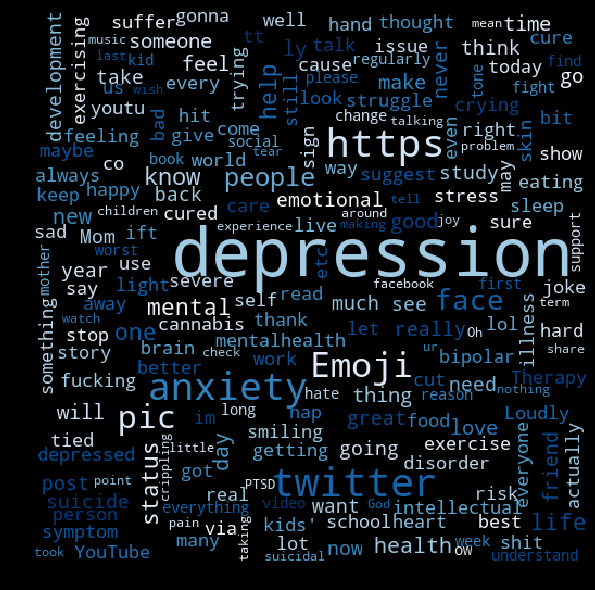

In [17]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

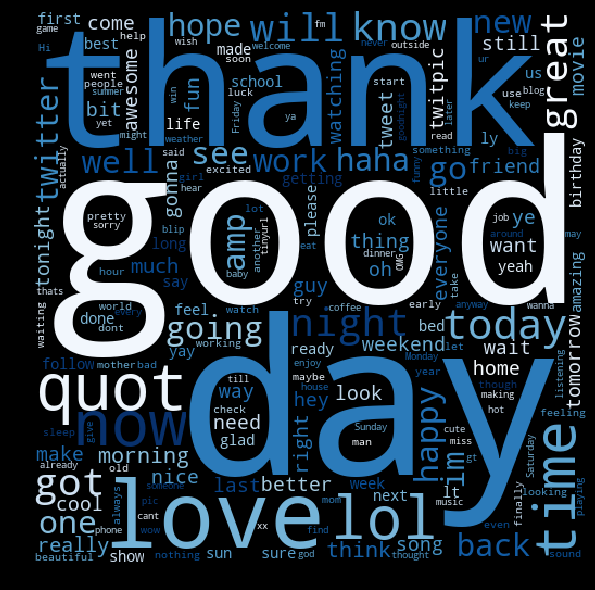

In [18]:
positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [19]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [20]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 


    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [21]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [22]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  1.0
Recall:  0.3684210526315789
F-score:  0.5384615384615384
Accuracy:  0.8899082568807339


In [23]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  1.0
Recall:  0.10526315789473684
F-score:  0.1904761904761905
Accuracy:  0.8440366972477065


In [24]:
pm = process_message('Lately I have been feeling unsure of myself as a person & an artist')
sc_tf_idf.classify(pm)

True

In [25]:
pm = process_message('Extreme sadness, lack of energy, hopelessness')
sc_tf_idf.classify(pm)

True

In [26]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_tf_idf.classify(pm)

True

In [27]:
pm = process_message('I am officially done with @kanyewest')
sc_tf_idf.classify(pm)

True

In [28]:
pm = process_message('Feeling down...')
sc_tf_idf.classify(pm)

True

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
